In [1]:
from glob import glob
import os
import numpy as np
import pandas
import matplotlib. pyplot as plt

In [2]:
import glob

# Get all CSV files in the 'norm' subfolder
norm_file_paths = glob.glob(r'C:\Users\venka\Downloads\dataset_CSV_and_EEA\norm\*.csv')

# Get all CSV files in the 'sch' subfolder
sch_file_paths = glob.glob(r'C:\Users\venka\Downloads\dataset_CSV_and_EEA\sch\*.csv')

# Combine both lists of file paths
all_file_paths = norm_file_paths + sch_file_paths

print(len(all_file_paths))


78


In [3]:
all_file_paths[0]

'C:\\Users\\venka\\Downloads\\dataset_CSV_and_EEA\\norm\\NC(1).csv'

In [4]:
frequent_file_paths = [i for i in all_file_paths if 'norm' in i.split('\\')[-2] and 'NC' in i.split('\\')[-1]]
infrequent_file_paths = [i for i in all_file_paths if 'sch' in i.split('\\')[-2] and 'SC' in i.split('\\')[-1]]

print(len(frequent_file_paths))
print(len(infrequent_file_paths))

33
45


In [5]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, iirnotch

# Bandpass filter setup
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

# Notch filter setup
def notch_filter(data, fs, notch_freq, quality=30):
    b, a = iirnotch(notch_freq, quality, fs)
    y = lfilter(b, a, data, axis=0)
    return y

# Normalize data
def normalize(data):
    # Min-max normalization or standard normalization based on requirements
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_normalized = (data - mean) / std
    return data_normalized

# Create epochs from CSV data
def create_epochs_from_csv(all_file_paths, window_duration_s=10, overlap_s=5, sampling_rate=128):
    # Load the CSV data into a DataFrame
    df = pd.read_csv(all_file_paths)
    
    # Convert DataFrame to numpy array
    data = df.to_numpy()

    # Apply bandpass filtering (0.5 to 45 Hz) and notch filtering (50 Hz)
    lowcut = 0.5
    highcut = 45.0 
    notch_freq = 50.0
    
    # Apply bandpass filter
    data = butter_bandpass_filter(data, lowcut, highcut, sampling_rate)
    
    # Apply notch filter
    data = notch_filter(data, sampling_rate, notch_freq)
    
    # Normalize data
    data = normalize(data)
    
    # Calculate window size and stride (in samples)
    window_size_samples = int(window_duration_s * sampling_rate)
    overlap_samples = int(overlap_s * sampling_rate)
    stride = window_size_samples - overlap_samples
    
    # Check if stride is positive
    if stride <= 0:
        raise ValueError("Stride must be greater than zero. Check window_duration_s and overlap_s values.")
    
    # Initialize list to store epochs
    epochs = []
    
    # Create epochs
    for start in range(0, data.shape[0] - window_size_samples + 1, stride):
        end = start + window_size_samples
        epoch = data[start:end, :]
        epochs.append(epoch)
    
    # Convert list of epochs to numpy array
    epochs_array = np.array(epochs)
    
    return epochs_array

In [6]:
sample_data = create_epochs_from_csv(frequent_file_paths[0],window_duration_s=10, overlap_s=5, sampling_rate=128)

In [7]:
sample_data.shape

(11, 1280, 16)

In [8]:
%%capture
control_epochs_array=[create_epochs_from_csv(i,window_duration_s=10, overlap_s=5, sampling_rate=128) for i in frequent_file_paths]
patient_epochs_array=[create_epochs_from_csv(i,window_duration_s=10, overlap_s=5, sampling_rate=128) for i in infrequent_file_paths]

In [9]:
control_epochs_array[0].shape,control_epochs_array[1].shape

((11, 1280, 16), (11, 1280, 16))

In [10]:
control_epoch_labels=[len(i)*[0] for i in control_epochs_array]
patient_epoch_labels=[len(i)*[1] for i in patient_epochs_array]
len(control_epoch_labels),len(patient_epoch_labels)

(33, 45)

In [11]:
epochs_array=control_epochs_array+patient_epochs_array
epochs_labels=control_epoch_labels+patient_epoch_labels
len(epochs_array),len(epochs_labels)

(78, 78)

In [12]:
groups=[[i]*len(j) for i,j in enumerate(epochs_array)]
len(groups)

78

In [13]:
epochs_array=np.vstack(epochs_array)
epochs_labels=np.hstack(epochs_labels)
groups_array=np.hstack(groups)

In [14]:
epochs_array.shape,epochs_labels.shape,groups_array.shape

((858, 1280, 16), (858,), (858,))

In [15]:
epochs_array=np.moveaxis(epochs_array,1,2)
epochs_array.shape

(858, 16, 1280)

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming epochs_array, epochs_labels, and groups_array are defined and preprocessed

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
train_features, test_features, train_labels, test_labels = train_test_split(
    epochs_array, epochs_labels, test_size=0.2, random_state=42, stratify=epochs_labels
)

# Print the shapes of the resulting sets
print(f'Training features shape: {train_features.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Testing features shape: {test_features.shape}')
print(f'Testing labels shape: {test_labels.shape}')

# Verify distribution of labels in training and testing sets
from collections import Counter
train_label_distribution = Counter(train_labels)
test_label_distribution = Counter(test_labels)

print(f'Training label distribution: {train_label_distribution}')
print(f'Testing label distribution: {test_label_distribution}')


Training features shape: (686, 16, 1280)
Training labels shape: (686,)
Testing features shape: (172, 16, 1280)
Testing labels shape: (172,)
Training label distribution: Counter({1: 396, 0: 290})
Testing label distribution: Counter({1: 99, 0: 73})


In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Get the shape of the train_features
n_samples, n_timesteps, n_features = train_features.shape

# Reshape to 2D for scaling (flattening timesteps and features for scaling)
train_features_reshaped = scaler.fit_transform(train_features.reshape(-1, n_features))
test_features_reshaped = scaler.transform(test_features.reshape(-1, n_features))

# Reshape back to 3D after scaling
train_features = train_features_reshaped.reshape(n_samples, n_timesteps, n_features)
test_features = test_features_reshaped.reshape(test_features.shape[0], test_features.shape[1], n_features)


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Dense, Dropout, BatchNormalization, LeakyReLU, LSTM, Bidirectional, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Add, GlobalAveragePooling1D

# Custom ResNet block
def resnet_block(input_tensor, filters, kernel_size=3, strides=1):
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])  # Skip connection (ResNet)
    x = LeakyReLU()(x)
    
    return x

# Custom ResNet-based feature extractor for EEG
def custom_resnet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet Blocks
    x = resnet_block(x, 64, strides=1)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 512, strides=2)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    return tf.keras.Model(inputs, x)

# LSTM classifier using ResNet features
def cnn_lstm_resnet(input_shape):
    # Use the ResNet feature extractor
    resnet_model = custom_resnet(input_shape)
    
    model = Sequential()
    
    # Add ResNet feature extractor as first part of the model
    model.add(resnet_model)
    
    # Reshape the output to 3D (batch_size, timesteps=1, features)
    model.add(Reshape((1, 512)))  # Reshape for LSTM to expect 3D input

    # LSTM layers for temporal dependencies
    model.add(Bidirectional(LSTM(100, return_sequences=False)))  # Bi-directional LSTM layer with 100 units
    
    # Fully connected layers with L2 regularization
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization to avoid overfitting
    model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.0001) 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (1280, 16)  

model = cnn_lstm_resnet(input_shape)
model.summary()

# Ensure train and test features are in the correct shape
train_features = train_features.transpose(0, 2, 1)  # (batch_size, timesteps, features)
test_features = test_features.transpose(0, 2, 1)

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model1
history = model.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), 
                    epochs=100, 
                    batch_size=32, 
                    )

# Evaluate the model
loss, accuracy = model.evaluate(test_features, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 512)               1770880   
                                                                 
 reshape_2 (Reshape)         (None, 1, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              490400    
 nal)                                                            
                                                                 
 dense_22 (Dense)            (None, 512)               102912    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                      

6/6 [==============================] - 0s 19ms/step - loss: 0.4550 - accuracy: 0.9128
Test Loss: 0.4549776613712311
Test Accuracy: 0.9127907156944275
6/6 [==============================] - 1s 17ms/step

Confusion Matrix:
[[58 15]
 [ 0 99]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.89        73
           1       0.87      1.00      0.93        99

    accuracy                           0.91       172
   macro avg       0.93      0.90      0.91       172
weighted avg       0.92      0.91      0.91       172


AUC Score: 0.9987546699875467


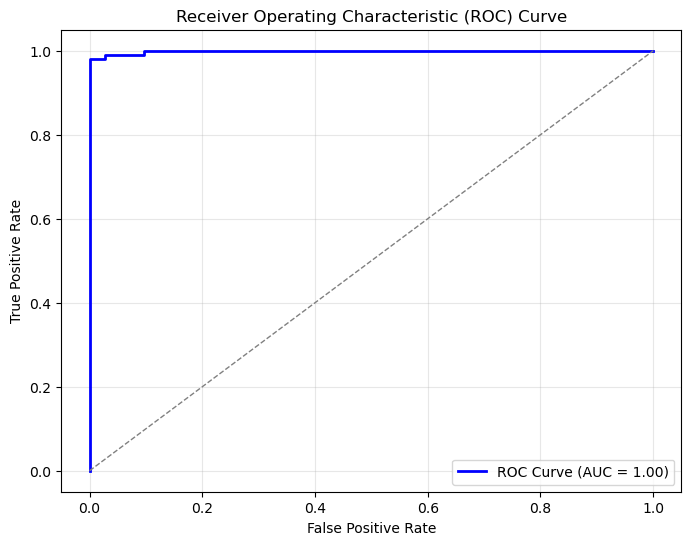

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Evaluate the model
loss, accuracy = model.evaluate(test_features, test_labels)

# Print basic evaluation results
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get the predicted labels
y_pred_prob = model.predict(test_features)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (assuming binary classification)

# Calculate AUC score
auc_score = roc_auc_score(test_labels, y_pred_prob)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Generate a classification report with Precision, Recall, F1-Score
class_report = classification_report(test_labels, y_pred)

# Print additional performance metrics
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"\nAUC Score: {auc_score}")

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, AveragePooling1D, Dense, Dropout, BatchNormalization, 
    LeakyReLU, LSTM, Bidirectional, Input, Reshape, MultiHeadAttention, Add, 
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


# Custom ResNet block
def resnet_block(input_tensor, filters, kernel_size=3, strides=1):
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])  # Skip connection (ResNet)
    x = LeakyReLU()(x)
    
    return x

# Custom ResNet-based feature extractor
def custom_resnet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet Blocks
    x = resnet_block(x, 64, strides=1)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 512, strides=2)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    return tf.keras.Model(inputs, x)

# LSTM classifier with ResNet features and multi-head attention
def cnn_lstm_resnet_with_attention(input_shape, num_heads=8):
    # Use the ResNet feature extractor
    resnet_model = custom_resnet(input_shape)
    
    inputs = Input(shape=input_shape)
    resnet_features = resnet_model(inputs)  # ResNet outputs (batch_size, features)
    
    # Reshape ResNet output to add temporal dimension
    x = Reshape((1, 512))(resnet_features)  # (batch_size, timesteps=1, features)
    
    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=512)(x, x)
    
    # Combine attention output with LSTM
    x = Bidirectional(LSTM(100, return_sequences=False))(attention_output)
    
    # Fully connected layers with L2 regularization
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    
    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Build and compile the model
    model = tf.keras.Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Ensure train and test features are in the correct shape
# Expected shape: (batch_size, 1280, 16)
if train_features.shape[1:] != (1280, 16):
    train_features = train_features.transpose(0, 2, 1)
if test_features.shape[1:] != (1280, 16):
    test_features = test_features.transpose(0, 2, 1)

# Verify shapes
print(f"Training features shape: {train_features.shape}")
print(f"Testing features shape: {test_features.shape}")

# Define input shape
input_shape = (1280, 16)

# Build the model with multi-head attention
model_with_attention = cnn_lstm_resnet_with_attention(input_shape)
model_with_attention.summary()

# Train the model
# history = model_with_attention.fit(
#     train_features, train_labels,
#     validation_data=(test_features, test_labels),
#     epochs=100,
#     batch_size=32
# )

# Evaluate the model
loss, accuracy = model_with_attention.evaluate(test_features, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
# Count trainable and non-trainable parameters
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_with_attention.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_with_attention.non_trainable_weights])

print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")




Training features shape: (686, 1280, 16)
Testing features shape: (172, 1280, 16)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1280, 16)]   0           []                               
                                                                                                  
 model_2 (Functional)           (None, 512)          1770880     ['input_4[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 512)       0           ['model_2[0][0]']                
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 1, 512)      8401408     ['reshape_1[0][0]',              
 eadAttenti

6/6 [==============================] - 0s 20ms/step - loss: 0.0804 - accuracy: 0.9942
Test Loss: 0.08041903376579285
Test Accuracy: 0.9941860437393188
6/6 [==============================] - 1s 18ms/step

Confusion Matrix:
[[72  1]
 [ 0 99]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        73
           1       0.99      1.00      0.99        99

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172


AUC Score: 1.0


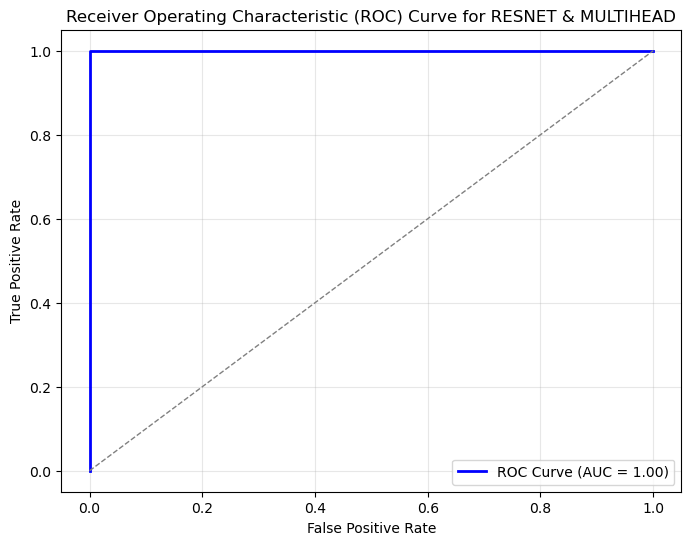

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
# Ensure correct shape of features
if train_features.shape[1:] != (1280, 16):
    train_features = train_features.transpose(0, 2, 1)
if test_features.shape[1:] != (1280, 16):
    test_features = test_features.transpose(0, 2, 1)

# Evaluate the model
loss, accuracy = model_with_attention.evaluate(test_features, test_labels)

# Print basic evaluation results
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get the predicted labels
y_pred_prob = model_with_attention.predict(test_features)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate AUC score
auc_score = roc_auc_score(test_labels, y_pred_prob)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Generate a classification report with Precision, Recall, F1-Score
class_report = classification_report(test_labels, y_pred)

# Print additional performance metrics
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"\nAUC Score: {auc_score}")

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RESNET & MULTIHEAD')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [21]:
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, AveragePooling1D, Dense, Dropout, BatchNormalization, 
    LeakyReLU, LSTM, Bidirectional, Input, Reshape, MultiHeadAttention, Add, 
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Ensure train and test features are in the correct shape
# Expected shape: (batch_size, 1280, 16)
train_features = train_features.transpose(0, 2, 1) if train_features.shape[1] != 1280 else train_features
test_features = test_features.transpose(0, 2, 1) if test_features.shape[1] != 1280 else test_features

# Check the final shapes
print(f"Training features shape: {train_features.shape}")
print(f"Testing features shape: {test_features.shape}")

# Transformer block
def transformer_block(input_tensor, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(input_tensor, input_tensor)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(input_tensor + attention_output)  # Skip connection
    
    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(input_tensor.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(attention_output + ff_output)  # Skip connection
    
    return ff_output

# Transformer-based model
def transformer_model(input_shape, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer to reduce dimensionality
    x = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Transformer blocks
    x = transformer_block(x, num_heads, key_dim, ff_dim, dropout_rate)
    x = transformer_block(x, num_heads, key_dim, ff_dim, dropout_rate)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Build and compile the model
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define input shape and build the model
input_shape = (1280, 16)
transformer = transformer_model(input_shape)
transformer.summary()

# # Train the Transformer model
# history_transformer = transformer.fit(train_features, train_labels,
#                                        validation_data=(test_features, test_labels),
#                                        epochs=100,
#                                        batch_size=32)

# Count trainable and non-trainable parameters
trainable_params_transformer = sum([tf.keras.backend.count_params(w) for w in transformer.trainable_weights])
non_trainable_params_transformer = sum([tf.keras.backend.count_params(w) for w in transformer.non_trainable_weights])

print(f"Trainable Parameters: {trainable_params_transformer}")
print(f"Non-Trainable Parameters: {non_trainable_params_transformer}")


Training features shape: (686, 1280, 16)
Testing features shape: (172, 1280, 16)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1280, 16)]   0           []                               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 1280, 64)     3136        ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 640, 64)     0           ['conv1d_26[0][0]']              
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 640, 64)     66368       ['max_pooling1d_2[0][0]',        
 eadAttenti

6/6 [==============================] - 1s 242ms/step - loss: 0.0583 - accuracy: 0.9884
Test Loss: 0.05834939330816269
Test Accuracy: 0.9883720874786377
6/6 [==============================] - 2s 239ms/step

Confusion Matrix:
[[73  0]
 [ 2 97]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        73
           1       1.00      0.98      0.99        99

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172


AUC Score: 0.9987546699875467


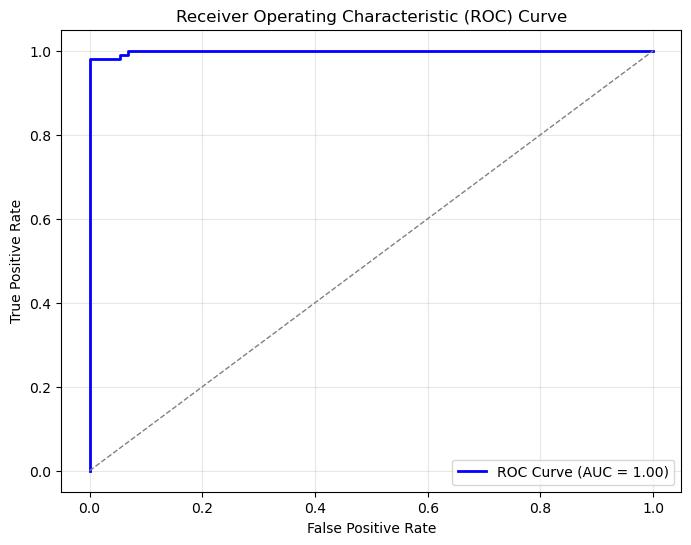

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the Transformer model
loss, accuracy = transformer.evaluate(test_features, test_labels)

# Print basic evaluation results
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get the predicted labels
y_pred_prob = transformer.predict(test_features)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate AUC score
auc_score = roc_auc_score(test_labels, y_pred_prob)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Generate a classification report with Precision, Recall, F1-Score
class_report = classification_report(test_labels, y_pred)

# Print additional performance metrics
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"\nAUC Score: {auc_score}")

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Autoencoder for preprocessing
def autoencoder(input_shape, encoding_dim=128):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    encoded = Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(encoded)
    decoded = Reshape(input_shape)(x)
    
    # Build autoencoder
    autoencoder_model = Model(inputs, decoded)
    encoder_model = Model(inputs, encoded)  # Encoder part only
    
    autoencoder_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder_model, encoder_model

# Build and train the autoencoder
input_shape = (1280, 16)
autoencoder_model, encoder_model = autoencoder(input_shape)
autoencoder_model.summary()

# Train the autoencoder
autoencoder_model.fit(train_features, train_features, epochs=50, batch_size=32, validation_split=0.2)

# Use the encoder to extract compressed features
compressed_train_features = encoder_model.predict(train_features)
compressed_test_features = encoder_model.predict(test_features)

# Build a new classifier using the compressed features
classifier = Sequential([
    Dense(128, activation='relu', input_shape=(compressed_train_features.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
classifier.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

# Train the classifier on compressed features
history_classifier = classifier.fit(compressed_train_features, train_labels,
                                     validation_data=(compressed_test_features, test_labels),
                                     epochs=100,
                                     batch_size=32)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1280, 16)]        0         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               2621568   
                                                                 
 dense_15 (Dense)            (None, 20480)             2641920   
                                                                 
 reshape (Reshape)           (None, 1280, 16)          0         
                                                                 
Total params: 5,263,488
Trainable params: 5,263,488
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 [==============================]

6/6 [==============================] - 0s 2ms/step - loss: 0.7905 - accuracy: 0.5349
Test Loss: 0.7905187606811523
Test Accuracy: 0.5348837375640869
6/6 [==============================] - 0s 2ms/step

Confusion Matrix:
[[18 55]
 [25 74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.25      0.31        73
           1       0.57      0.75      0.65        99

    accuracy                           0.53       172
   macro avg       0.50      0.50      0.48       172
weighted avg       0.51      0.53      0.51       172


AUC Score: 0.45482219454822204


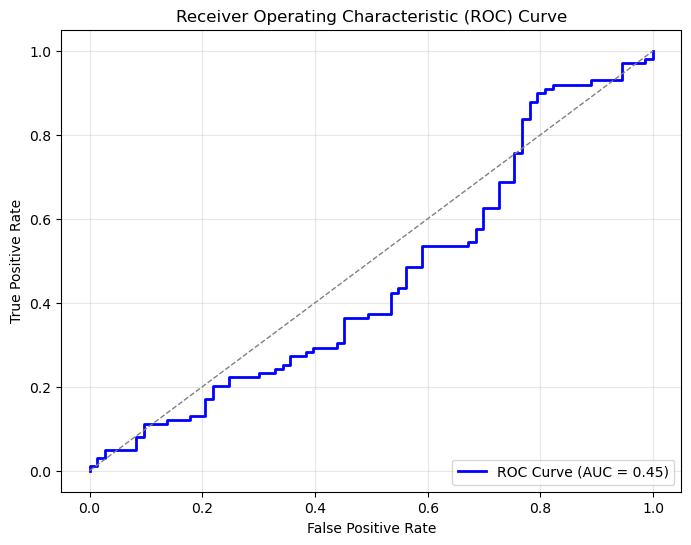

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the classifier model
loss, accuracy = classifier.evaluate(compressed_test_features, test_labels)

# Print basic evaluation results
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get the predicted labels
y_pred_prob = classifier.predict(compressed_test_features)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate AUC score
auc_score = roc_auc_score(test_labels, y_pred_prob)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Generate a classification report with Precision, Recall, F1-Score
class_report = classification_report(test_labels, y_pred)

# Print additional performance metrics
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"\nAUC Score: {auc_score}")

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


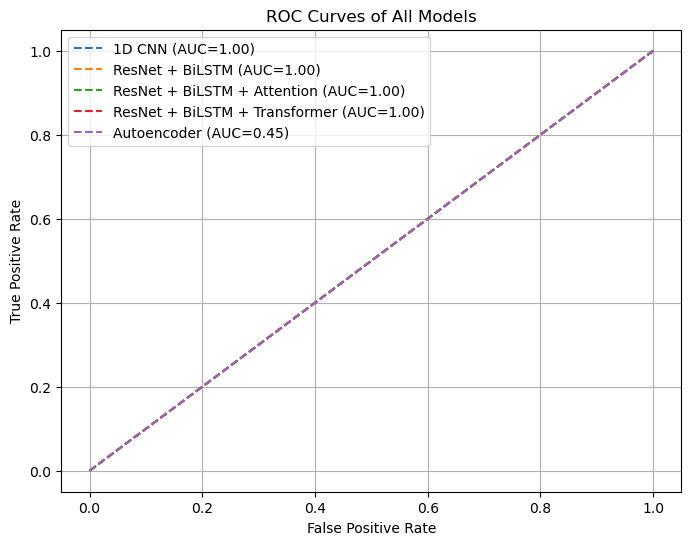

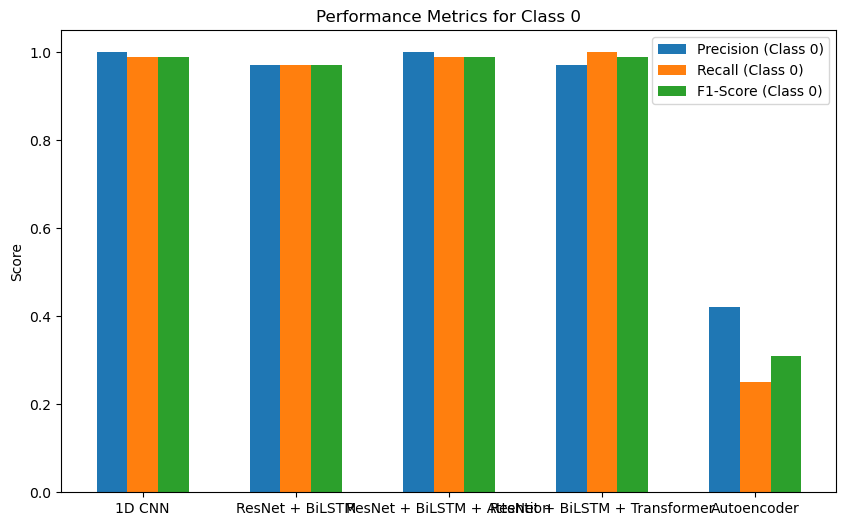

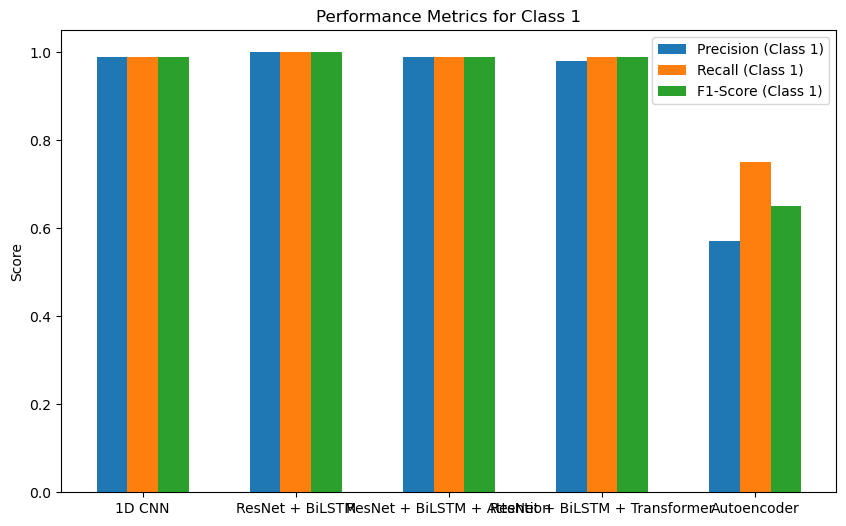

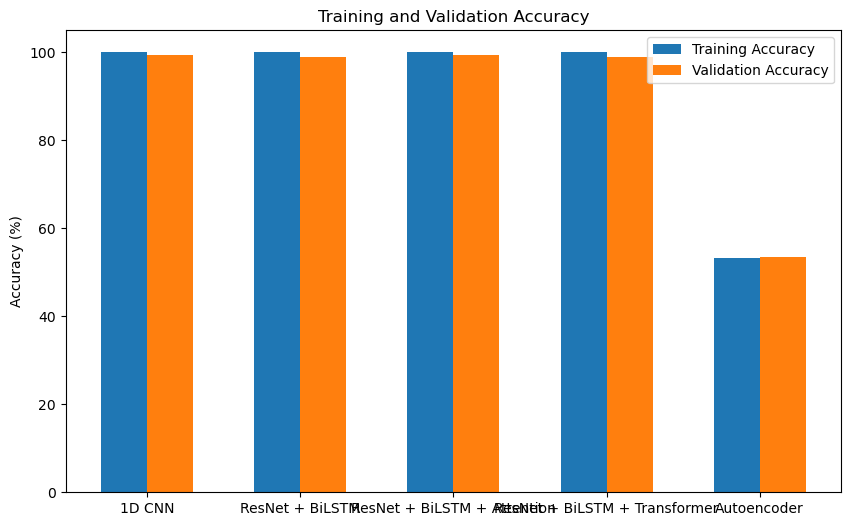

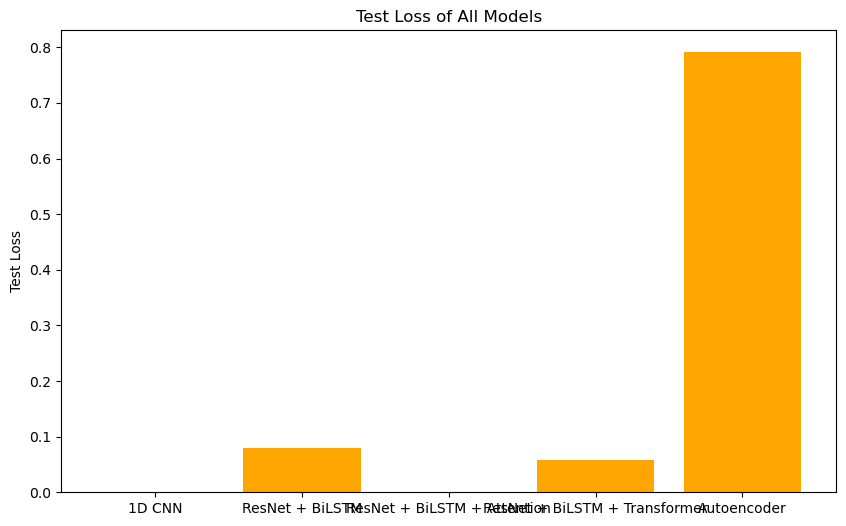

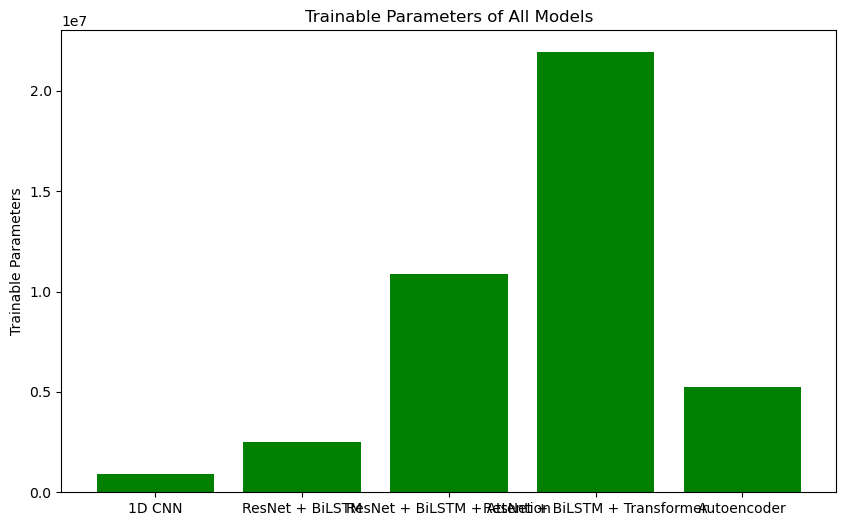

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their metrics from the table
models = ["1D CNN", "ResNet + BiLSTM", "ResNet + BiLSTM + Attention", 
          "ResNet + BiLSTM + Transformer", "Autoencoder"]

# Data from the performance table
train_accuracy = [100.00, 100.00, 100.00, 100.00, 53.22]
val_accuracy = [99.41, 98.83, 99.42, 98.84, 53.49]
test_loss = [None, 0.08, None, 0.058, 0.791]
auc_score = [1.0, 1.0, 1.0, 1.0, 0.45]
trainable_params = [914497, 2489889, 10891297, 21920101, 5263488]
precision_class_0 = [1.0, 0.97, 1.0, 0.97, 0.42]
recall_class_0 = [0.99, 0.97, 0.99, 1.0, 0.25]
f1_class_0 = [0.99, 0.97, 0.99, 0.99, 0.31]
precision_class_1 = [0.99, 1.0, 0.99, 0.98, 0.57]
recall_class_1 = [0.99, 1.0, 0.99, 0.99, 0.75]
f1_class_1 = [0.99, 1.0, 0.99, 0.99, 0.65]

# ROC Curve
plt.figure(figsize=(8, 6))
for model, auc in zip(models, auc_score):
    if auc is not None:
        plt.plot([0, 1], [0, 1], linestyle='--', label=f'{model} (AUC={auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Models')
plt.legend()
plt.grid()
plt.show()

# Precision, Recall, F1-Score for Class 0
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2
ax.bar(x - width, precision_class_0, width, label='Precision (Class 0)')
ax.bar(x, recall_class_0, width, label='Recall (Class 0)')
ax.bar(x + width, f1_class_0, width, label='F1-Score (Class 0)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Performance Metrics for Class 0')
ax.legend()
plt.show()

# Precision, Recall, F1-Score for Class 1
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2
ax.bar(x - width, precision_class_1, width, label='Precision (Class 1)')
ax.bar(x, recall_class_1, width, label='Recall (Class 1)')
ax.bar(x + width, f1_class_1, width, label='F1-Score (Class 1)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Performance Metrics for Class 1')
ax.legend()
plt.show()

# Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.3
ax.bar(x - width/2, train_accuracy, width, label='Training Accuracy')
ax.bar(x + width/2, val_accuracy, width, label='Validation Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training and Validation Accuracy')
ax.legend()
plt.show()

# Test Loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models, [loss if loss is not None else 0 for loss in test_loss], color='orange')
ax.set_ylabel('Test Loss')
ax.set_title('Test Loss of All Models')
plt.show()

# Trainable Parameters
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models, trainable_params, color='green')
ax.set_ylabel('Trainable Parameters')
ax.set_title('Trainable Parameters of All Models')
plt.show()
